In [1]:
import sys
sys.path.append('../codes')

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np

import seaborn as sns

from scipy.signal import hilbert
from scipy.spatial import ConvexHull

from kneed import KneeLocator

# %matplotlib notebook

In [3]:
sns.set_context('paper', font_scale=2, 
                rc={'lines.linewidth': 2,
                    'text.usetex' : True,
                    'image.interpolation': 'nearest',
                    'image.cmap': 'gray',
                    'figure.figsize': (10.0, 8.0)})
sns.set_style(style='whitegrid')
sns.set_palette('colorblind', color_codes=True)

In [4]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
#             print(line)
            lines.append(json.loads(line))
    return lines

In [5]:
# for k in range(0,8):
#     try:
#         df_train = pd.read_csv(f"../output/yolo/baseline/fold{k}/loss_train.csv", header=None)
#         df_val = pd.read_csv(f"../output/yolo/baseline/fold{k}/loss_val.csv", header=None)

#         print(f'fold {k}')
#         print('samples train: ', len(df_train))
#         print('samples val: ', len(df_val), '\n')
        
#     except FileNotFoundError as e:
#         print(f'fold {k} not ready\n')


In [6]:
def read_json(files_dir):
    experiment_metrics = load_json_arr(files_dir + '/metrics.json')
    
    iter_train = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
    loss_train = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]
    iter_val = [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x]
    loss_val = [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x]
    
    return iter_train, loss_train, iter_val, loss_val


# def read_json_detailed(files_dir,\
#                        keys=['total_loss',\
#                              'loss_cls',\
#                              'loss_box_reg',\
#                              'loss_rpn_cls',\
#                              'loss_rpn_loc',\
#                              'total_val_loss',\
#                              'val_loss_cls',\
#                              'val_loss_box_reg',\
#                              'val_loss_rpn_cls',\
#                              'val_loss_rpn_loc'\
#                              ]):
    
#     experiment_metrics = load_json_arr(files_dir + '/metrics.json')
        
#     losses = {k:[] for k in keys}
    
#     iters = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
    
#     for k in keys:
#         losses[k] = [x[k] for x in experiment_metrics if k in x]
        
#     return iters, losses


# def read_csv_yolo(files_dir, trunc=50000):
    
#     loss_train = pd.read_csv(files_dir + "/loss_train.csv", header=None)[0].to_list()
#     loss_val = pd.read_csv(files_dir + "/loss_val.csv", header=None)[0].to_list()
    
#     if trunc:
#         loss_train = loss_train[:trunc]
#         loss_val = loss_val[:trunc]
        
#     iter_train = list(np.arange(0,len(loss_train)))
#     iter_val = list(np.arange(0,len(loss_val)))
    
#     return iter_train, loss_train, iter_val, loss_val


def moving_average(x,w):    
    return np.convolve(x, np.ones(w), 'valid')/w

def get_results(experiment_folder, sampling=1, win_size=1, normalize=True):
    
    if 'yolo' in experiment_folder.lower():
        iter_train, loss_train, iter_val, loss_val = read_csv_yolo(experiment_folder)    
        
    else:
        iter_train, loss_train, iter_val, loss_val = read_json(experiment_folder)    
    
    if win_size>1:
        iter_train = iter_train[int(win_size/2):-int(win_size/2)]
        iter_val = iter_val[int(win_size/2):-int(win_size/2)]        
    
    # 
    loss_train = moving_average(loss_train, win_size)
    loss_val = moving_average(loss_val, win_size)     
            
    min_loss_train =  np.min(np.array(loss_train))
    min_loss_val =  np.min(np.array(loss_val))
    
    if normalize:
    #     iter_train = iter_train
        loss_train = loss_train/min_loss_train
    #     iter_val = iter_val
        loss_val = loss_val/min_loss_val
    
    return iter_train, loss_train, iter_val, loss_val

def plot_results(iter_train, loss_train, iter_val, loss_val,  save_fig=False):
    
    plt.plot(iter_train, loss_train, label='train')
    plt.plot(iter_val, loss_val, label='val')

#     plt.legend(['train', 'val'], loc='upper right')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    
    if save_fig:
        plt.savefig(experiment_folder + "/train_val_loss.png")
    return plt


def plot_results_ax(ax, iter_train, loss_train, iter_val, loss_val,  save_fig=False):
    
    ax.plot(iter_train, loss_train, label='train')
    ax.plot(iter_val, loss_val , label='val')

#     plt.legend(['train', 'val'], loc='upper right')
    ax.set_xlabel('iteration')
    ax.set_ylabel('loss')
    
    if save_fig:
        ax.savefig(experiment_folder + "/train_val_loss.png")
    return ax
    
def results_summary(it, loss):
    it_mean = np.mean(it)
    it_median = np.median(it)
    it_std = np.std(it)
    
    l_mean = np.mean(loss)
    l_median = np.median(loss)
    l_std = np.std(loss)
    
    print("iterations")
    print("mean: ", it_mean)
    print("median: ", it_median)
    print("std: ", it_std)
        
    print("\nloss")
    print("mean: ", l_mean)
    print("median: ", l_median)
    print("std: ", l_std)       
    
def approx_diff2(x):
    l = []
    for i in range(1, len(x)-1):
        l.append(x[i+1] + x[i-1] - 2 * x[i])
        
    return np.array(l)

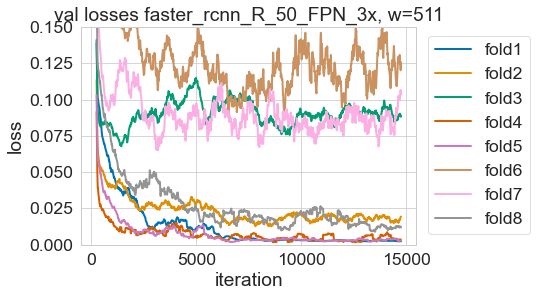

In [7]:
model = "faster_rcnn_R_50_FPN_3x"
# model = "yolo"
obj = 'tire'
s = 1 #sampling
w = 511 #window size
normalize=False

for f in range(8):
#     print(f)
    experiment_folder = f'../output/augmentations-low/{model}/mbg_train{f}_{obj}'
#     experiment_folder = f'../output/gan2x_stopcriteria_tuned/{model}/mbg_gan2x_train{f}'
    
    
    
    
#     experiment_folder = f'../output/{model}/baseline/stopcriteria/fold{f}'
    
    
    
    iter_train, loss_train, iter_val, loss_val = get_results(experiment_folder, 
                                                             sampling=s, win_size=w, normalize=normalize)
    
    
    plt.plot(iter_val, loss_val, label=f"fold{f+1}")
#     plt.axvline(x=6000, linestyle='--', label=None, c='gray')
#     plt.axvline(x=8000, linestyle='--', label=None, c='gray')
    
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim([-.0, 0.15])
plt.title(f'val losses {model}, w={w}')
plt.legend(bbox_to_anchor=(1.01, 1))   
plt.show()

In [8]:
# for f in [1,7]:
# #     print(f)
# #     experiment_folder = f'../output/v1_new_val/{model}/mbg_train{f}_{obj}'
    
# #     experiment_folder = f'../output/test/{model}/mbg_train{f}_tire'
    
#     experiment_folder = f'../output/v1_new_val3/{model}/mbg_train{f}_tire'

#     #     experiment_folder = f'../output/gan2x_stopcriteria_tuned/{model}/mbg_gan2x_train{f}'
    
#     iters, losses = read_json_detailed(experiment_folder)
#     print(f'fold{f+1}')
    
    
#     w_temp = 7
#     idx_valid = np.where(np.array(iters) < 3865)[0][-1]
    
    
#     plt.figure(figsize=(16,4))
#     plt.subplot(1,2,1)
#     l = []
#     for k in losses.keys():
#         if 'val' in k:
#             continue
#         plt.plot(moving_average(losses[k][:idx_valid], w_temp))
#         l.append(k)
#     plt.legend(l)
#     plt.ylim([0, 0.6])

# #     plt.subplot(1,2,2)
# #     l = []
# #     for k in losses.keys():
# #         if not 'val' in k:
# #             continue
# #         plt.plot(moving_average(losses[k], w))
# #         l.append(k)
# #     plt.legend(l)

# #     plt.ylim([0, 0.1])
#     plt.show()

In [9]:
from fvcore.common.file_io import PathManager

from detectron2.data import get_detection_dataset_dicts, MetadataCatalog
from utils.evaluation import CfnMat
from utils.register_datasets import register_mosquitoes
import contextlib
import torch
import io
from pycocotools.coco import COCO
from detectron2.structures.boxes import Boxes, BoxMode, pairwise_iou

register_mosquitoes()

/home/wesley.passos/miniconda3/envs/mosquitoes/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
def cnf_mat(pred, gt, thr=0.5):

    gt_overlaps = torch.zeros(len(gt))
    overlaps = pairwise_iou(pred, gt)

    for j in range(min(len(pred), len(gt))):

        max_overlaps, argmax_overlaps = overlaps.max(dim=0)

        # find which gt box is 'best' covered (i.e. 'best' = most iou)
        gt_ovr, gt_ind = max_overlaps.max(dim=0)
        assert gt_ovr >= 0

        # find the proposal box that covers the best covered gt box
        box_ind = argmax_overlaps[gt_ind]

        # record the iou coverage of this gt box
        gt_overlaps[j] = overlaps[box_ind, gt_ind]
        assert gt_overlaps[j] == gt_ovr

        # mark the proposal box and the gt box as used
        overlaps[box_ind, :] = -1
        overlaps[:, gt_ind] = -1

    tp = (gt_overlaps >= thr).int().sum().item()
    assert tp >= 0

    fp = len(pred) - tp
    assert fp >= 0

    fn = len(gt) - tp
    assert fn >= 0

    return tp, fp, fn

In [11]:
def compute_metrics(predictions, thr = 0.5):


    per_img = []
    total = {    
    "tp": 0,
    "fp": 0,
    "fn": 0,
    "tn": -1,
    "pr": 0,
    "rc": 0,
    "f1": 0
    }

    for pred in predictions:    
        if len(pred['instances']) == 0:
            continue

        pred_instances = pred["instances"]

        pred_boxes = [
                    BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS) for obj in pred_instances
            ]
        pred_boxes = torch.as_tensor(pred_boxes).reshape(-1, 4)  # guard against no boxes
        pred_boxes = Boxes(pred_boxes)


        ann_ids = coco_api.getAnnIds(imgIds=pred["image_id"])
        anno = coco_api.loadAnns(ann_ids)

        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS) for obj in anno
            if obj["iscrowd"] == 0
            ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)   

        tp, fp, fn = cnf_mat(pred_boxes, gt_boxes, thr=thr)

    #     print(gt_boxes)
    #     print(pred_boxes)
    #     print(tp, fp, fn)    
    #     print("*"*10)

        per_img.append({
                        "img_id": pred["image_id"],
                        "gt": len(gt_boxes),
                        "tp": tp,
                        "fp": fp,
                        "fn": fn,
                    })

        total["tp"] += tp
        total["fp"] += fp
        total["fn"] += fn
    total["pr"] += total["tp"] /(total["tp"] +total["fp"] + 1e-16)
    total["rc"] += total["tp"] /(total["tp"] +total["fn"] + 1e-16)
    
    total['f1'] = (2*total["pr"]*total["rc"])/(total["pr"] + total["rc"]+ 1e-16)
        
    return total

In [12]:
result = dict()
confidence_thr = 0.6
k = 2

for k in range(8):
    result[f'fold_{k}'] = dict()

    for confidence_thr in [0.3, 0.5, 0.7, 0.9, 0.99]:
        result[f'fold_{k}'][f'{confidence_thr}'] = dict()

        for iter_nb in range(100,10100,100):


            model_name = "faster_rcnn_R_50_FPN_3x"

        #     iter_nb = 100
            test_set = f"mbg_val{k}_tire"

            predictions = torch.load(f"../output/valid_f1_during_training/{model_name}/mbg_train{k}_tire/inference_iter{iter_nb:05d}/instances_predictions.pth")
            dataset_dicts = get_detection_dataset_dicts([test_set], filter_empty=False)


            metadata = MetadataCatalog.get(test_set)
            json_file = PathManager.get_local_path(metadata.json_file)

            with contextlib.redirect_stdout(io.StringIO()):
                coco_api = COCO(json_file)


            result[f'fold_{k}'][f'{confidence_thr}'][f'{iter_nb:04d}'] = compute_metrics(predictions, thr = confidence_thr)    
        


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category 

FileNotFoundError: [Errno 2] No such file or directory: '../output/valid_f1_during_training/faster_rcnn_R_50_FPN_3x/mbg_train6_tire/inference_iter10000/instances_predictions.pth'

fold 1


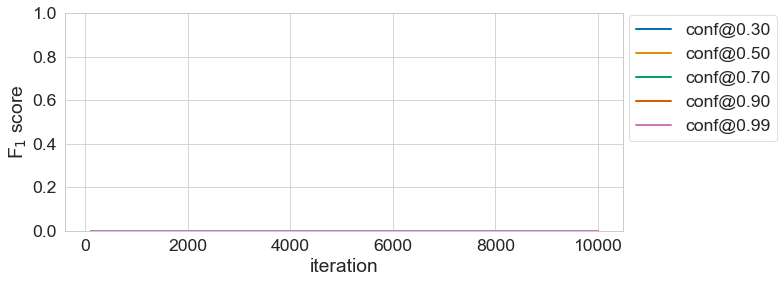

fold 2


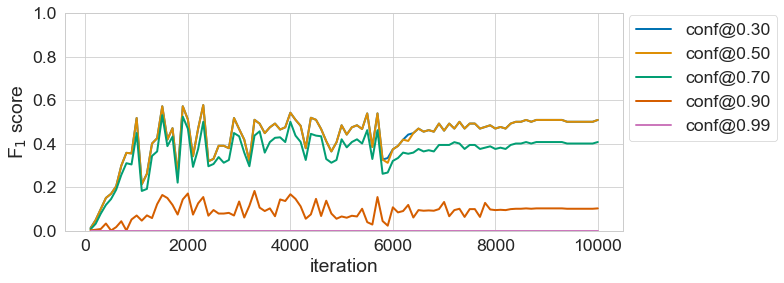

fold 3


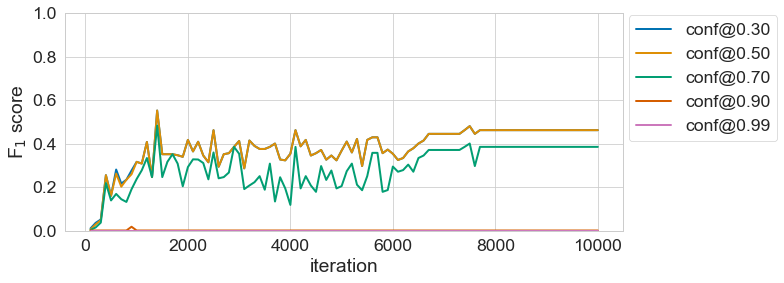

fold 4


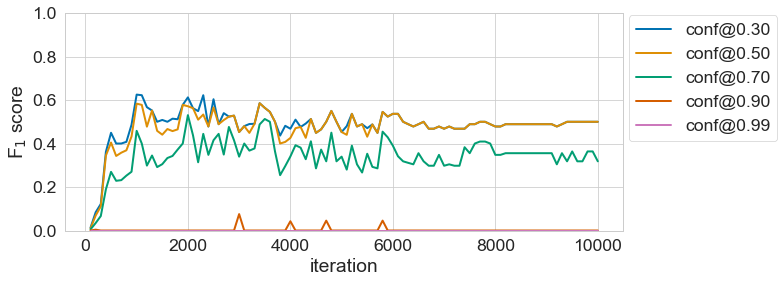

fold 5


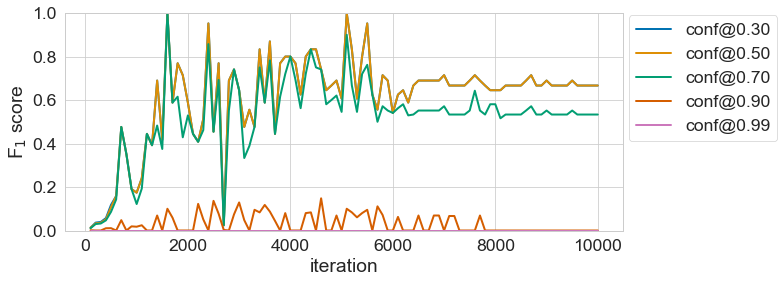

fold 6


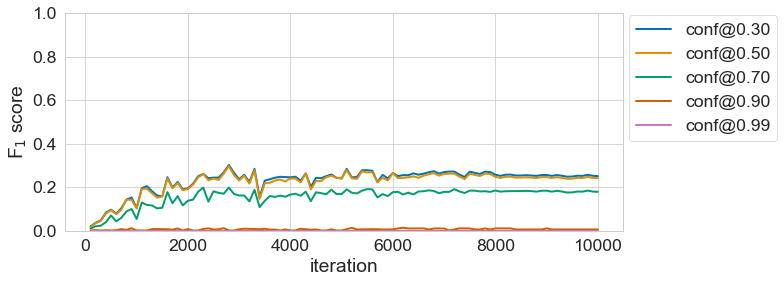

fold 7


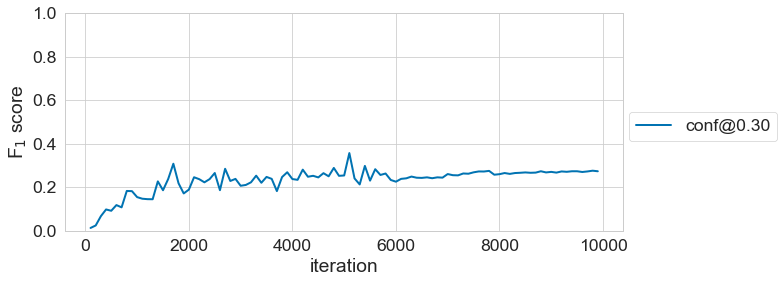

In [13]:
legend = []


for fold, results_per_fold in result.items():
    print(f'fold {int(fold[-1])+1}')
    plt.figure(figsize=(10,4))

    for confidence, metric_iter in results_per_fold.items():
        i = []
        f1 = []
        pr = []
        rc = []
        legend.append(f'conf@{float(confidence):.2f}')



        for iteration, metrics in metric_iter.items():    
            i.append(int(iteration))
            f1.append(metrics['f1'])

            pr.append(metrics['pr'])  
            rc.append(metrics['rc'])  


        plt.plot(i,f1)
    plt.legend(legend, loc=(1.01,.41))
    plt.xlabel('iteration')
    plt.ylabel('F$_1$ score')
    plt.ylim([0,1])

    plt.show()

In [ ]:
# iter_train, loss_train, iter_val, loss_val = get_results("../output/gan2x_fold2/faster_rcnn_R_50_FPN_1x/mbg_gan2x_train2/", 
#                                                              sampling=s, win_size=w, normalize=normalize)
    
# p = plot_results(iter_train, loss_train, iter_val, loss_val)    
# plt.ylim([-.0, 0.45])
    
# p.legend()
# p.show()  

# print(iter_val[np.argmin(loss_val)], np.min(loss_val))

In [ ]:
# loss_val[iter_val.index(5975)]

In [ ]:
# iters = [4999, 9999, 14999, 19999, 24999, 29999, 34999, 39999, 44999]#, 49999]

# list_df = {}

# for i in iters:
#     list_df[f'model_{i}'] = pd.read_csv(f"../output/gan2x_fold2/faster_rcnn_R_50_FPN_1x/mbg_gan2x_train2/tire_faster_rcnn_R_50_FPN_1x_GAN_model_{i:07d}_val2.csv")



In [ ]:
# for i in iters:
#     print(loss_val[iter_val.index(i)], list_df[f'model_{i}']['F1'].max(),)

In [ ]:
# data_pr = []
# data_rc = []
# data_f1 = []

# for i in iters:
#     data_pr.append(list_df[f'model_{i}']['Pr'])
#     data_rc.append(list_df[f'model_{i}']['Rc'])
#     data_f1.append(list_df[f'model_{i}']['F1'])
    
# plt.figure(figsize=(20,4))
# plt.subplot(1,3,1)    
# plt.boxplot(data_pr, vert=0)
# plt.title('Precision')
# plt.yticks(ticks=np.arange(1,10), labels=iters)
# plt.xlim([0,0.8])

# plt.subplot(1,3,2)    
# plt.boxplot(data_rc, vert=0)
# plt.title('Recall')
# plt.yticks(ticks=np.arange(1,10), labels=iters)
# plt.xlim([0,0.8])

# plt.subplot(1,3,3)    
# plt.boxplot(data_f1, vert=0)
# plt.title('F1')
# plt.xlim([0,0.8])
# plt.yticks(ticks=np.arange(1,10), labels=iters)


# plt.show()


fold1


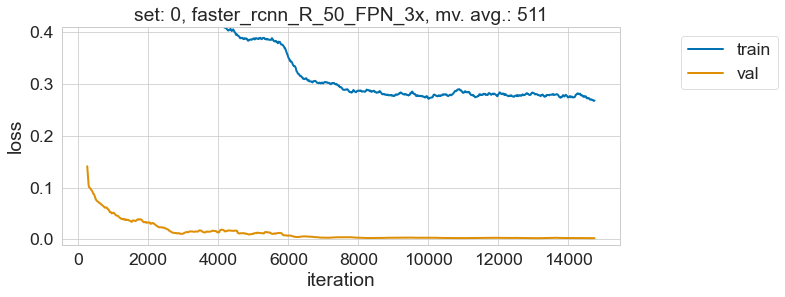

fold2


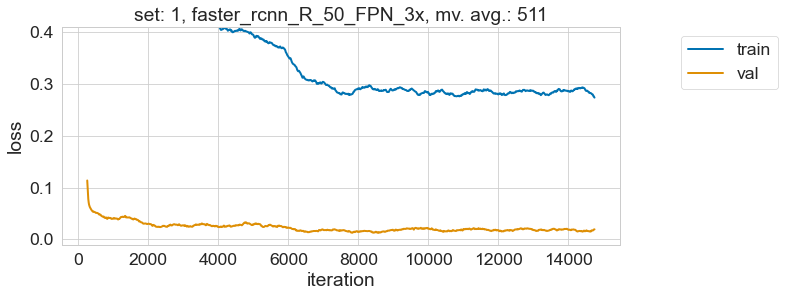

fold3


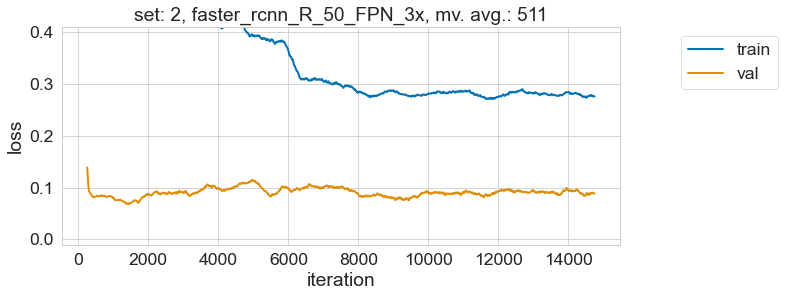

fold4


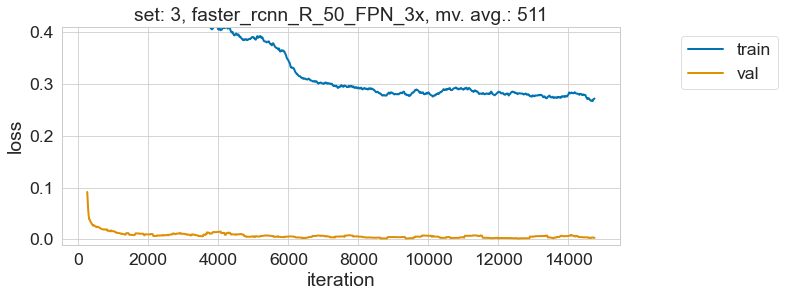

fold5


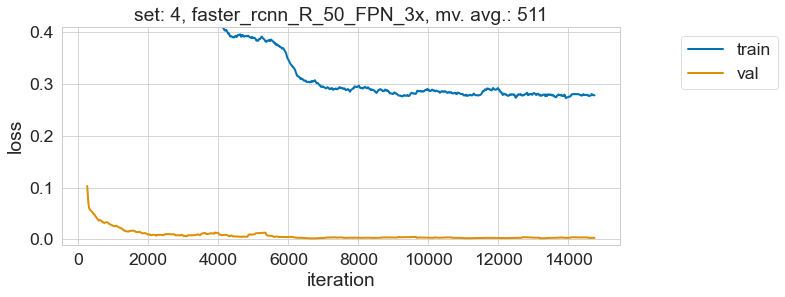

fold6


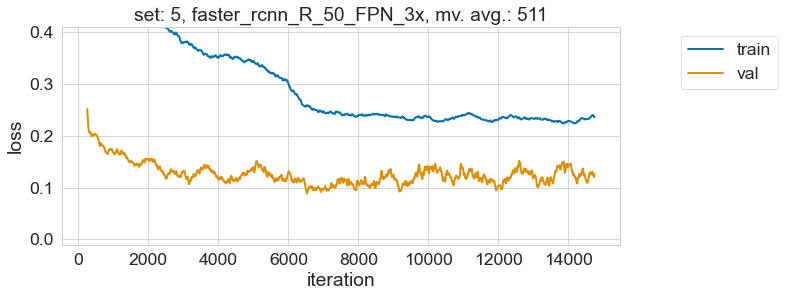

fold7


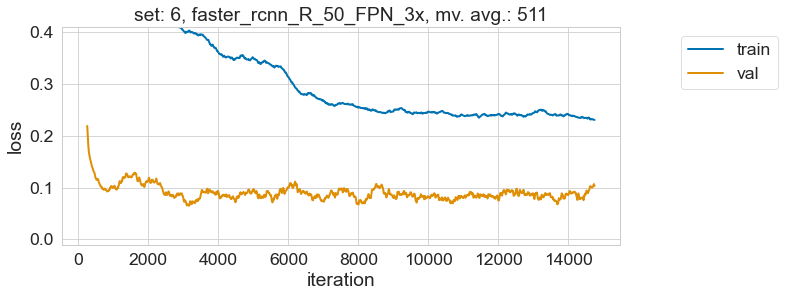

fold8


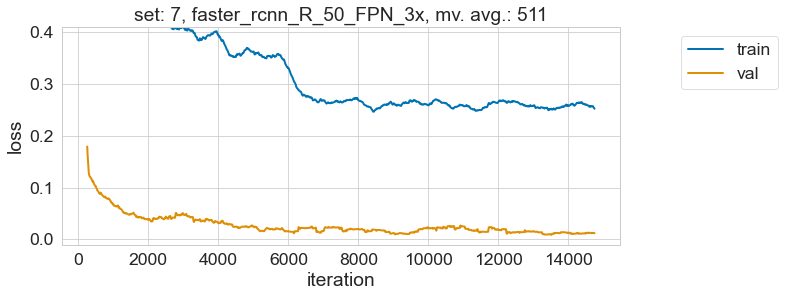

In [14]:
s = 1 #sampling
w = 511 #window size

normalize=False

all_mins_itr_val = []
all_mins_loss_val = []

iter_train = dict()
loss_train = dict()
iter_val = dict()
loss_val = dict()

for f in range(8):    
    print(f'fold{f+1}')
    experiment_folder = f'../output/augmentations-low/{model}/mbg_train{f}_{obj}'
#     experiment_folder = f'../output/gan2x_stopcriteria_tuned/{model}/mbg_gan2x_train{f}'    
#     experiment_folder = f'../output/{model}/baseline_aug/stopcriteria/fold{f}'
    
    
    
    
    iter_train[f'set_{f}'], loss_train[f'set_{f}'], iter_val[f'set_{f}'], loss_val[f'set_{f}'] = get_results(\
                                                            experiment_folder, 
                                                             sampling=s, win_size=w, normalize=normalize)
    
        
    all_mins_itr_val.append(iter_val[f'set_{f}'][np.argmin(loss_val[f'set_{f}'])])
    all_mins_loss_val.append(np.min(loss_val[f'set_{f}']))
    
    
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(111)    
    
    ax1 = plot_results_ax(ax1, iter_train[f'set_{f}'], loss_train[f'set_{f}'],
                 iter_val[f'set_{f}'], loss_val[f'set_{f}'])    
#     ax2 = ax1.twinx()            
    
#     p.ylim([0,3])
    
#     min_iter = 416
#     median_iter = 2619
#     max_iter = 6574
    
#     p.axvline(x=min_iter, ymin=0, ymax=1, c='g', linestyle='--', label='min')
#     p.axvline(x=median_iter, ymin=0, ymax=1, c='orange', linestyle='--', label='median')
#     p.axvline(x=max_iter, ymin=0, ymax=1, c='r', linestyle='--', label='max')
    
    
#     plt.axhline(y=1, xmin=0, xmax=1, c='r')
#     plt.vlines(kl.elbow, ymin=0, ymax=1, colors='b', linestyles='--')    
#     plt.xlim([220, 5000])    
    
    
    ax1.legend(['train', 'val'], bbox_to_anchor =(1.3, 1.))
    
#     metrics_legend = []
#     for confidence, metric_iter in result[f'fold_{f}'].items():
#         if float(confidence) != 0.5:
#             continue
        
#         i = []
#         f1 = []
#         pr = []
#         rc = []
        

#         for iteration, metrics in metric_iter.items():    
#             i.append(int(iteration))
#             f1.append(metrics['f1'])

#             pr.append(metrics['pr'])  
#             rc.append(metrics['rc'])  


# #         ax2.plot(i,pr, '-c', i,rc, '-g', i,f1, '-r')
# #         ax2.legend([f'Pr@{float(confidence):.2f}', f'Rc@{float(confidence):.2f}', f'F$_1$@{float(confidence):.2f}'], bbox_to_anchor =(1.37, .75))
#         ax2.plot(i, f1, '-r')
    
#         metrics_legend.extend([f'F$_1$@{float(confidence):.2f}'])
    
#     ax2.legend(metrics_legend, bbox_to_anchor =(1.37, .75))
        
        
    ax1.set_ylim([-0.01,0.41])   
#     ax2.set_ylim([-0.01,1.01])
#     ax2.set_ylabel('metrics', color='r')
    ax1.grid(True)
#     ax2.grid(True)
        
    plt.title(f'set: {f}, {model}, mv. avg.: {w}')
#     plt.legend(legend, bbox_to_anchor =(1., 1.))
    
    plt.show()  
    

In [15]:
# # minimums found manualy
# all_mins = [5097, 2594, 416, 2134, 5675, 2645, 1267, 6574]
# print('min:', np.min(all_mins))
# print('median: ', np.median(all_mins))
# print('max: ', np.max(all_mins))

fold1


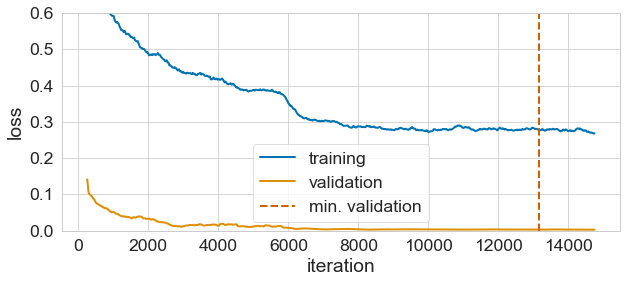

first accpt min: 0.0022 @ 13141
global min: 0.0022 @ 13149


fold2


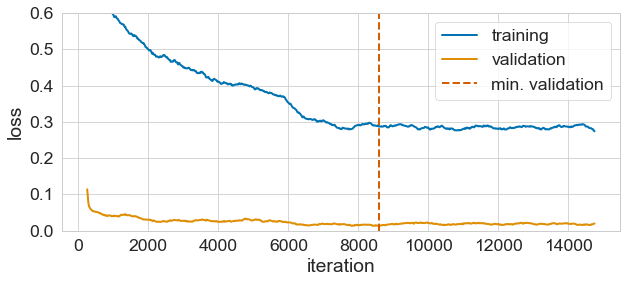

first accpt min: 0.0126 @ 7820
global min: 0.0125 @ 8576


fold3


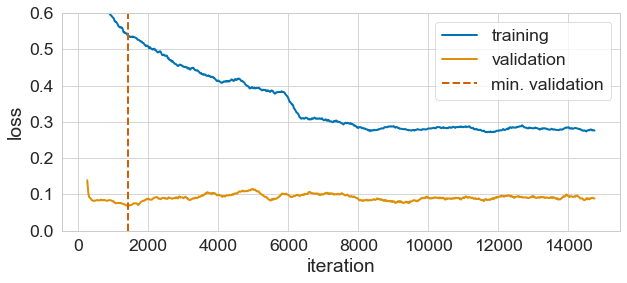

first accpt min: 0.0684 @ 1407
global min: 0.0678 @ 1431


fold4


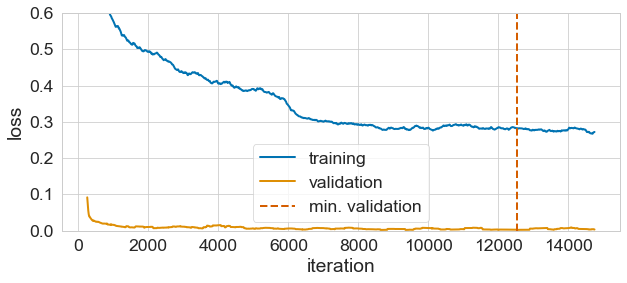

first accpt min: 0.0016 @ 12534
global min: 0.0016 @ 12538


fold5


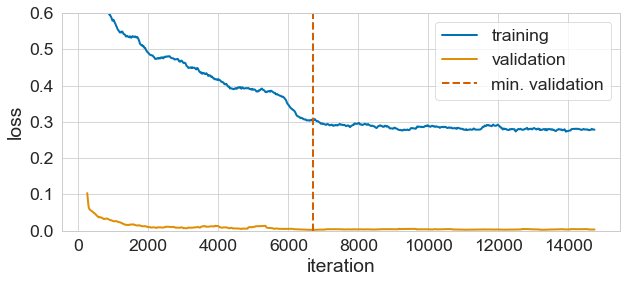

first accpt min: 0.0017 @ 6705
global min: 0.0016 @ 6707


fold6


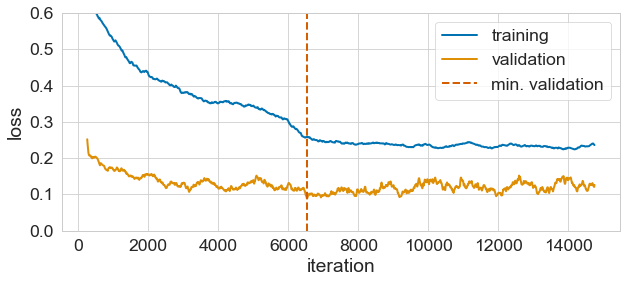

first accpt min: 0.0890 @ 6528
global min: 0.0882 @ 6533


fold7


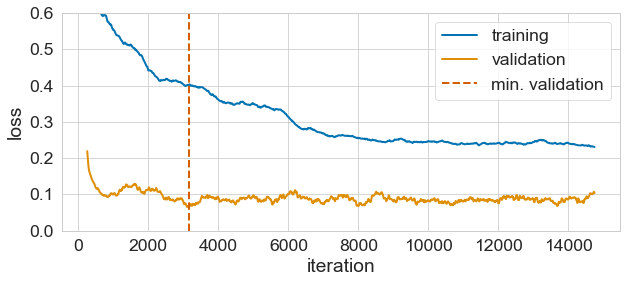

first accpt min: 0.0657 @ 3099
global min: 0.0650 @ 3174


fold8


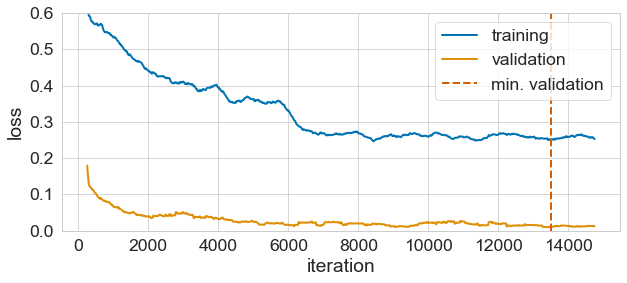

first accpt min: 0.0088 @ 13497
global min: 0.0088 @ 13504




In [16]:
# automaticly find first minimium
f = 0
tol = 0.01 # multiplicative
w=511
normalize = False


iter_train = dict()
loss_train = dict()
iter_val = dict()
loss_val = dict()

all_accptd_mins_itr_val = []

for f in range(8):    
    print(f"fold{f+1}")
    experiment_folder = f'../output/augmentations-low/{model}/mbg_train{f}_{obj}'
#     experiment_folder = f'../output/gan2x_stopcriteria_tuned/{model}/mbg_gan2x_train{f}'

    
#     experiment_folder = f'../output/{model}/baseline/stopcriteria/fold{f}'
    
    
    
    
    iter_train[f'set_{f}'], loss_train[f'set_{f}'], iter_val[f'set_{f}'], loss_val[f'set_{f}'] = get_results(\
                                                            experiment_folder, 
                                                             sampling=s, win_size=w, normalize=normalize)
    
    
    arg_global_min = np.argmin(loss_val[f'set_{f}'])
    global_min_iter = iter_val[f'set_{f}'][arg_global_min]
    
    global_min = np.min(loss_val[f'set_{f}'])

    # find the arg where is the first acceptable min
    arg_first_acc_min = np.where(loss_val[f'set_{f}'] <= global_min*(1+tol))[0][0]

    # get correspondent values of minium acceptable
    first_acc_min_iter = iter_val[f'set_{f}'][arg_first_acc_min]
    first_acc_min_loss = loss_val[f'set_{f}'][arg_first_acc_min]
    
    all_accptd_mins_itr_val.append(first_acc_min_iter)
    
    plt.figure(figsize=(10,4))

    plt.plot(iter_train[f'set_{f}'], loss_train[f'set_{f}'], label='training')    
    plt.plot(iter_val[f'set_{f}'], loss_val[f'set_{f}'], label='validation')
    
    plt.xlabel('iteration')
    plt.ylabel('loss')
    
    
    plt.ylim([-0.0, .6])
#     plt.xlim([0, 50000])
    
#     plt.axvline(x=first_acc_min_iter, ymin=0, ymax=1, c='orange', linestyle='--', label='accptd. min')
    plt.axvline(x=global_min_iter, ymin=0, ymax=1, c='r', linestyle='--', label='min. validation')
    
    plt.legend()      
    
    plt.show()
    
    print(f"first accpt min: {first_acc_min_loss:.4f} @ {first_acc_min_iter}")
    print(f"global min: {global_min:.4f} @ {global_min_iter}")
    
    print("\n")

# iter_val[f'set_{f}'], loss_val[f'set_{f}']

In [17]:
for s, (i, l) in enumerate(zip(all_mins_itr_val, all_mins_loss_val)):
    print(f"set {s} min loss at iteration {i:05d}: {l:.5f}")


print("\nELBOW")
print(f"\nmin: {np.min(all_accptd_mins_itr_val):05d}")
print(f"max: {np.max(all_accptd_mins_itr_val):05d}")
print(f"median: {np.median(all_accptd_mins_itr_val):05.0f}")
print(f"mean: {np.mean(all_accptd_mins_itr_val):05.0f}")
print(f"std: {np.std(all_accptd_mins_itr_val):05.0f}")

print("\nGLOBAL")
print(f"\nmin: {np.min(all_mins_itr_val):05d}")
print(f"max: {np.max(all_mins_itr_val):05d}")
print(f"median: {np.median(all_mins_itr_val):05.0f}")
print(f"mean: {np.mean(all_mins_itr_val):05.0f}")
print(f"std: {np.std(all_mins_itr_val):05.0f}")

set 0 min loss at iteration 13149: 0.00217
set 1 min loss at iteration 08576: 0.01254
set 2 min loss at iteration 01431: 0.06778
set 3 min loss at iteration 12538: 0.00157
set 4 min loss at iteration 06707: 0.00164
set 5 min loss at iteration 06533: 0.08824
set 6 min loss at iteration 03174: 0.06505
set 7 min loss at iteration 13504: 0.00878

ELBOW

min: 01407
max: 13497
median: 07262
mean: 08091
std: 04308

GLOBAL

min: 01431
max: 13504
median: 07642
mean: 08202
std: 04296


In [ ]:
# import collections
# print([item for item, count in collections.Counter(iter_train).items() if count > 1])

In [18]:
all_train_loss =[]
all_val_loss = []

all_min_val_loss = []
all_iter_min_val_loss = []

w = 511 #window size
s = 1 #sampling

for f in range(8):
    experiment_folder = f'../output/augmentations-low/{model}/mbg_train{f}_{obj}'
#     experiment_folder = f'../output/gan2x_stopcriteria_tuned/{model}/mbg_gan2x_train{f}'

#     experiment_folder = f'../output/{model}/baseline/stopcriteria/fold{f}'

    

    iter_train, loss_train, iter_val, loss_val = get_results(experiment_folder, sampling=s, win_size=w)
   
    all_train_loss.append(loss_train)
    all_val_loss.append(loss_val)
    
    all_min_val_loss.append(np.min(loss_val))
    all_iter_min_val_loss.append(iter_val[np.argmin(loss_val)])
    
    
mean_loss_train = np.mean(all_train_loss, axis=0)
std_loss_train = np.std(all_train_loss, axis=0)

mean_loss_val = np.mean(all_val_loss, axis=0)
std_loss_val = np.std(all_val_loss, axis=0)    

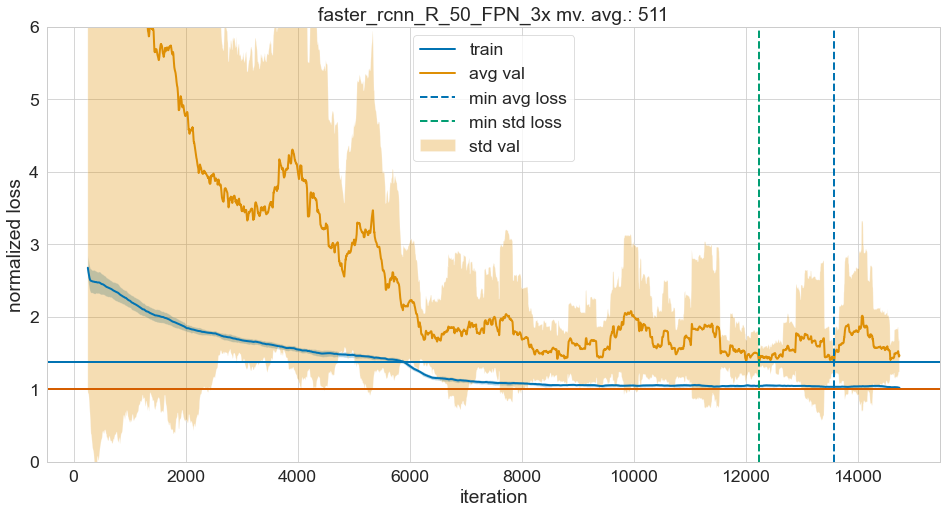

In [19]:
plt.figure(figsize=(16,8))
plt.plot(iter_train, mean_loss_train, label='train')
plt.fill_between(iter_train, mean_loss_train-std_loss_train, mean_loss_train+std_loss_train,
                alpha=0.3)


plt.plot(iter_val, mean_loss_val , label = 'avg val')
plt.fill_between(iter_val, mean_loss_val-std_loss_val, mean_loss_val+std_loss_val, alpha=0.3, label='std val')

# plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('normalized loss')

plt.axhline(y=1, xmin=0, xmax=1, c='r')
plt.axhline(y=np.min(mean_loss_val), xmin=0, xmax=1, c='b')

plt.axvline(x=iter_val[np.argmin(mean_loss_val)], ymin=0, ymax=1, c='b', ls='--', label='min avg loss')
plt.axvline(x=iter_val[np.argmin(std_loss_val)], ymin=0, ymax=1, c='g', ls='--', label='min std loss')

# plt.legend(['train', 'val'], loc='upper right')
plt.legend()
# 

plt.title(f'{model} mv. avg.: {w}')


# plt.xlim([42200, 42300])
plt.ylim([-0, 6])

plt.show()

In [20]:
it_min = iter_val[np.argmin(mean_loss_val)]
it_min_std = iter_val[np.argmin(std_loss_val)]

print(f'iter min loss: {it_min}, loss: {mean_loss_val[np.argmin(mean_loss_val)]:.3f} +/- {std_loss_val[np.argmin(mean_loss_val)]:.3f}')
print(f'iter min loss std: {it_min_std}, loss: {mean_loss_val[np.argmin(std_loss_val)]:.3f} +/- {std_loss_val[np.argmin(std_loss_val)]:.3f}')

# print(it_min, it_min_std, mean_loss_val[it_min], std_loss_val[it_min])
# print(std_loss_val[it_min_std])

iter min loss: 13570, loss: 1.374 +/- 0.176
iter min loss std: 12231, loss: 1.396 +/- 0.105


In [21]:
iterat = it_min
ind = np.where(np.array(iter_val)==iterat)[0][0]


print(f'mean loss: {mean_loss_val[ind]:.3f} +/- {std_loss_val[ind]:.3f}')

mean loss: 1.374 +/- 0.176


In [53]:
metric = 'F1'
model = 'faster_rcnn_R_50_FPN_1x'
iteration = 7642
t = ''
obj = 'tire'
set_ = 'val'
    
directory = 'augmentations-low_valid'

lst = []

for f in range(8):
    
    fold = f  

    df = pd.read_csv(f"../output/{directory}/{model}/mbg_train{fold}_{obj}/{obj}_{model}_augm-low_model_{iteration:07d}_{set_}{f}.csv")

    a = df.groupby(['score']).max()
    a = a.unstack()[f'{metric}']
#     if fold not in [1, 2, 3, 4,]:
    if fold not in [0,]:
        lst.append(a)

#     plt.figure(figsize=(8,6))
#     sns.heatmap(a, annot=True, fmt='.3g', cmap='viridis', vmin=0, vmax=1, cbar=True)
#     plt.title(f'{metric} - {model} - iteration {iteration} - fold {fold} ({t})')
#     plt.show()

df_concat = pd.concat(lst)
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_stds =  by_row_index.std()

   
print('mean_matrix')
plt.figure(figsize=(10,6))
sns.heatmap(df_means, annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1, cbar=True)
plt.xlabel(r'confidence threshold ($\tau$)')
plt.ylabel('consistency threshold ($\mu$)')
# plt.title(f'{metric} - {model} - iteration {iteration} - mean ({t})')
plt.show()

print('std_matrix')
plt.figure(figsize=(10,6))
sns.heatmap(df_stds, annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1, cbar=True)
# plt.title(f'{metric} - {model} - iteration {iteration} - std ({t})')
plt.xlabel(r'confidence threshold ($\tau$)')
plt.ylabel('consistency threshold ($\mu$)')
plt.show()


print('mean - std matrix')
plt.figure(figsize=(8,5))
sns.heatmap(df_means - df_stds, annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1, cbar=True)
plt.title(f'{metric} - {model} - iteration {iteration} - mean-std({t})')
plt.show()

print('mean + std matrix')
plt.figure(figsize=(8,5))
sns.heatmap(df_means + df_stds, annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1, cbar=True)
plt.title(f'{metric} - {model} - iteration {iteration} - mean+std ({t})')
plt.show()


mean_matrix


IndexError: Inconsistent shape between the condition and the input (got (11, 1) and (11,))

<Figure size 720x432 with 0 Axes>

In [55]:
# BEST CONFIGURATION INDEPENDENTLY
metric = 'F1'
model = 'faster_rcnn_R_50_FPN_1x'
iteration = 7642
t = ''
obj = 'tire'
set_ = 'val'

for fold in range(8):
    df_read = pd.read_csv(f"../output/augmentations-low_valid/{model}/mbg_train{fold}_{obj}/{obj}_{model}_augm-low_model_{iteration:07d}_{set_}{fold}.csv")
    
    if fold == 0:        
        df = pd.DataFrame(df_read.iloc[df_read['F1'].argmax()]).T.reset_index(drop=True)
        continue      
        
        
    df = df.append(pd.DataFrame(df_read.iloc[df_read['F1'].argmax()]).T.reset_index(drop=True))
    
df.drop(['Unnamed: 0', 'score'], axis=1, inplace=True)
# print(df.columns)
print(df.to_string(index=False, justify='left'))

 TP    FP     FN     Pr   Rc   F1   AP50
 0.00 114.00   0.00 0.00 0.00 0.00   nan
13.00   2.00   2.00 0.87 0.87 0.87 85.35
 9.00   2.00  10.00 0.82 0.47 0.60 37.55
12.00   4.00  10.00 0.75 0.55 0.63 52.70
11.00   1.00   0.00 0.92 1.00 0.96 81.91
16.00  18.00 159.00 0.47 0.09 0.15  7.99
22.00  36.00  88.00 0.38 0.20 0.26 14.39
15.00  13.00  35.00 0.54 0.30 0.38 18.46


In [54]:
pd.options.display.float_format = "{:,.2f}".format

In [70]:
# set score and voting params
set_ = 'val'
metric = 'F1'
model = 'faster_rcnn_R_50_FPN_1x'
iteration = 7642
obj = 'tire'
t = ''
score =[0.8]
# voting =[0.4]

for fold in range(8):
    df_read = pd.read_csv(f"../output/augmentations-low_valid/{model}/mbg_train{fold}_{obj}/{obj}_{model}_augm-low_model_{iteration:07d}_{set_}{fold}.csv")
    
    if fold == 0:   
#         df_ = df_read[df_read.score.isin(score) & df_read.voting.isin(voting)].copy()
        df_ = df_read[df_read.score.isin(score)].copy()
#         df_['fold'] = int(fold)
        df = pd.DataFrame(df_).reset_index(drop=True)
        continue      
        
#     df_ = df_read[df_read.score.isin(score) & df_read.voting.isin(voting)].copy()
    df_ = df_read[df_read.score.isin(score)].copy()
#     df_['fold'] = fold
    df = df.append(pd.DataFrame(df_).reset_index(drop=True))
    
df.drop(['Unnamed: 0', 'score'], axis=1, inplace=True)
# df.set_index('fold', inplace=True)
# print(df.columns)
# print(df.to_latex(index=False)) 
df

,TP,FP,FN,Pr,Rc,F1,AP50
0,0,24,0,0.00,0.00,0.00,nan
0,13,2,2,0.87,0.87,0.87,85.35
0,9,2,10,0.82,0.47,0.60,37.55
0,11,2,11,0.85,0.50,0.63,49.73
0,11,1,0,0.92,1.00,0.96,81.91
0,13,7,162,0.65,0.07,0.13,6.83
0,20,25,90,0.44,0.18,0.26,13.60
0,14,9,36,0.61,0.28,0.38,17.43


In [ ]:
df_val = pd.read_csv("../output/v1_new_val3/faster_rcnn_R_50_FPN_1x/mbg_train0_watertank/watertank_faster_rcnn_R_50_FPN_1x_model_0014176_margin0_val_tube.csv")

plt.scatter(df_val['Pr'],df_val['Rc'] )
plt.xlabel('precision')
plt.ylabel('recall')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()

plt.show()

In [ ]:
df_val[(df_val['Rc'] > 0.85) & (df_val['Pr'] > 0.85)]

In [57]:
import os

In [69]:
# fold = "../output/paper_reprod_val2/faster_rcnn_R_50_FPN_3x/"
fold = "../output/augmentations-low_valid/faster_rcnn_R_50_FPN_1x/"
obj = 'tire'
# it=4078
it=7642


p = []

for i in range(8):
    if i==0: continue
#     if i in [1, 2, 3, 4,]: continue

#     p.append(pd.read_csv(os.path.join(fold, f'mbg_train{i}_tire', f'{obj}_faster_rcnn_R_50_FPN_1x_model_{it:07d}_val{i}.csv')))    
    p.append(pd.read_csv(os.path.join(fold, f'mbg_train{i}_tire', f'{obj}_faster_rcnn_R_50_FPN_1x_augm-low_model_{it:07d}_val{i}.csv')))

pd.DataFrame(np.mean(p, axis=0))

,0,1,2,3,4,5,6,7,8
0,0.00,0.05,16.14,63.00,41.29,0.34,0.52,0.39,43.63
1,1.00,0.10,15.29,37.86,42.14,0.41,0.51,0.44,43.57
2,2.00,0.20,14.57,24.14,42.86,0.48,0.51,0.47,43.47
3,3.00,0.30,14.00,17.14,43.43,0.55,0.50,0.50,42.97
4,4.00,0.40,14.00,15.00,43.43,0.57,0.50,0.51,42.97
5,5.00,0.50,14.00,13.29,43.43,0.62,0.50,0.52,42.97
6,6.00,0.60,13.86,10.71,43.57,0.66,0.50,0.54,42.89
7,7.00,0.70,13.57,9.00,43.86,0.70,0.49,0.54,42.07
8,8.00,0.80,13.00,6.86,44.43,0.74,0.48,0.55,41.77
9,9.00,0.90,11.71,4.71,45.71,0.79,0.44,0.53,38.56


In [ ]:
for k, d in enumerate(p):
    print(f"fold {k+2}")
    print(d)

In [ ]:
pd.DataFrame(np.std(p, axis=0))[7]